# Define the problem

# How can we predict the emergency through tweets?

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies)

But, it’s not always clear whether a person’s words are actually announcing a disaster. Through this project we want to solve this problem using some advanced technologies of NLP and accuratley classify between emergency and non-emergency tweets.

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import os
import io
import json

import sys
sys.path.insert(1, '../src')

from features import build_features as bf
from visualization import visualize as vs

from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### Loading the Data

In [2]:
tweet_data = pd.read_csv('../data/raw/train.csv')
tweet_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##  Checking out null values

In [3]:
#Missing values
tweet_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
#Missing values Percentage
(tweet_data.isnull().sum()/len(tweet_data))*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

## Cleaning the data

In [5]:
#The most values we are missing is location and we dont have any other data to replace it.
#Lets drop out the missing keyword values as they contribute less than 1 percent 
def cleaning_data(tweet_data):
    tweet_data = tweet_data.drop(labels=["location", "id"], axis=1)
    tweet_data['keyword'] = tweet_data['keyword'].replace(np.nan, "NAN")
    print((tweet_data.isnull().sum()/len(tweet_data))*100)
    return tweet_data

In [6]:
tweet_data = cleaning_data(tweet_data)

keyword    0.0
text       0.0
target     0.0
dtype: float64


## Exploring the Data (EDA)

In [7]:
#Lets check out if we equal proportion of the data
tweet_data.groupby("target").count()

,keyword,text
target,,
0,4342,4342
1,3271,3271


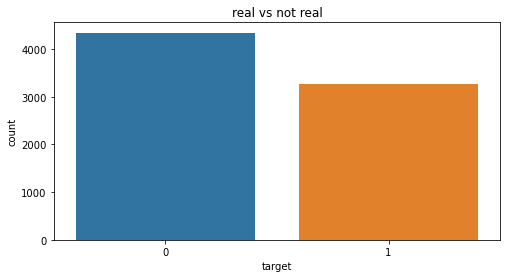

In [8]:
#It looks like we have slightly more non-disaster value compared to disaster value but
# there is no wide gap.
vs.proportion(tweet_data)

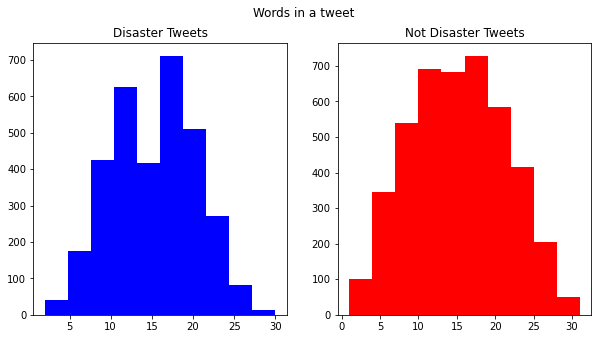

In [9]:
#We can see that overall not disaster tweets have more words
#compared to disaster tweets.
vs.word_count(tweet_data)

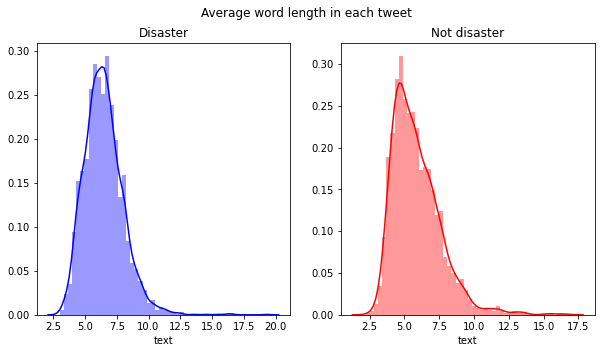

In [10]:
#The avg word length is very similar.
vs.avg_word_length(tweet_data)

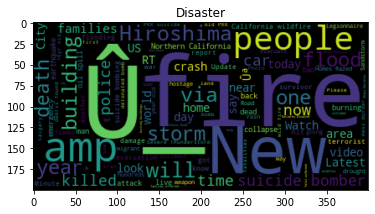

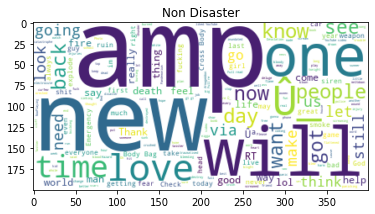

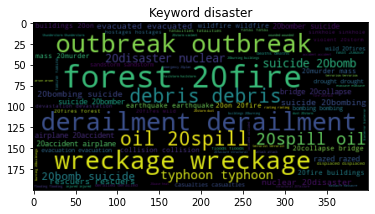

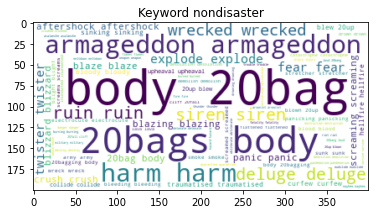

In [11]:
#We can see that disaster tweets usally have "Fire, Suicide bombing, car crash e.t.c" and
# non disaster has more words like "love, people,good e.t.c "

#We can see the keywords are a better indicator distinguishing between disaster and non disaster.
vs.word_cloud(tweet_data)

## --Preprocessing the data--

In [12]:
def pre_processing_data(tweet_data):
    #random shuffle the data
    tweet_data = tweet_data.sample(frac=1)
    
    #Merging the text with key word
    tweet_data_text = tweet_data['keyword'].str.cat(tweet_data['text'], sep=' ')

    #Removing Stop words
    tweet_data_text = bf.remove_stopwords(tweet_data_text)
    
    #Train val split
    (train_text, train_labels), (val_text, val_labels) = bf.train_val_split(tweet_data_text, tweet_data['target'])
    
    #Tokenization
    text_tokenizer = Tokenizer(oov_token='<OOV>')
    
    text_tokenizer.fit_on_texts(train_text)
    
    maxlen_text = len(text_tokenizer.word_index)    
    
    #Sequencing
    sequences_text_train = text_tokenizer.texts_to_sequences(train_text)
    sequences_labels_train = np.array(train_labels)
    
    sequences_text_val = text_tokenizer.texts_to_sequences(val_text)
    sequences_labels_val = np.array(val_labels)
    
    #Padding
    padded_text_train = pad_sequences(sequences_text_train, padding='post', maxlen=maxlen_text)
    padded_text_val = pad_sequences(sequences_text_val, padding='post', maxlen=maxlen_text)
    
    #Saving the tokenizer
    bf.save_tokenizer(text_tokenizer)
    
    return (padded_text_train, sequences_labels_train),(padded_text_val, sequences_text_val)

In [13]:
(train_texts, train_labels), (val_texts, val_labels) = pre_processing_data(tweet_data)

## --Establishing a Baseline--

In [22]:
train_labels.shape

(6090,)

In [14]:
with open('../src/models/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [15]:
tokenizer